In [1]:
import healpy as hp
from scipy import interpolate as interp
import matplotlib.pyplot as plt
import numpy as np
from pixell import enmap,curvedsky,utils,powspec,enplot
from pixell import reproject as rp
import matplotlib as mpl
import coop_post_processing as cpp
from astropy.io import fits
from astropy import units as u
from scipy import signal
from astropy.cosmology import Planck15 as cosmo, z_at_value
import coop_setup_funcs as csf
# set plot params
mpl.font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 3}
plt.rcParams.update({'font.size': 12})


mpl.rcParams['figure.figsize'] = [6.0, 4.0]
mpl.rcParams['figure.dpi'] = 140


In [5]:
def get_hp_map(nside, ra, dec, mask, smth):
    map   = np.zeros((hp.nside2npix(nside)))
    pix = hp.ang2pix(nside, ra, dec, lonlat=True)
    weight = 1.
    np.add.at(map, pix, weight)
    masked_map = map * mask
    mean = sum(masked_map)/sum(mask)
    newmap   = map/mean - 1
    newmap_masked = newmap * mask
    print("Mean of number density map: ", mean)
    print("Mean of overdensity map: ", sum(newmap_masked)/sum(mask))
    hp.mollview(newmap_masked)
    if smth != 0:
        smthmap = hp.sphtfunc.smoothing(newmap_masked, fwhm = np.deg2rad(smth))*mask
    else:
        smthmap = newmap_masked
    return smthmap
def get_nd_map(nside, ra, dec, mask, smth):
    map   = np.zeros((hp.nside2npix(nside)))
    pix = hp.ang2pix(nside, ra, dec, lonlat=True)
    weight = 1.
    np.add.at(map, pix, weight)
    if smth != 0:
        smthmap = hp.sphtfunc.smoothing(map, fwhm = np.deg2rad(smth))*mask
    else:
        smthmap = map
    return smthmap


In [12]:
mode = 'des'

In [13]:
if mode == 'buzzard':
    rm_hdu = fits.open("/mnt/raid-cita/mlokken/buzzard/catalogs/buzzard_1.9.9_3y3a_rsshift_run_redmagic_highdens.fit")
    rm     = rm_hdu[1].data
    rm_ra  = rm['RA']
    rm_dec = rm['dec']
    rm_z   = rm['zredmagic']
    rm_hdu.close()

    rm_mask = hp.read_map("/mnt/raid-cita/mlokken/data/redmagic/y3_gold_2.2.1_wide_sofcol_run_redmapper_v6.4.22_redmagic_highdens_0.5_vlim_zmask_hpx.fit")
#     mask = mask_hdu[1].data
#     mask_hdu.close()
#     nside = 4096
#     pix = mask['HPIX']
#     rm_mask = np.zeros(hp.nside2npix(nside))
#     np.add.at(rm_mask, pix, 1.)
if mode == 'des':
    rm_hdu = fits.open("/mnt/raid-cita/mlokken/data/redmagic/y3_gold_2.2.1_wide_sofcol+deep_mof_run_redmagic_highdens.fit")
    rm     = rm_hdu[1].data
    rm_ra  = rm['RA']
    rm_dec = rm['dec']
    rm_z   = rm['zredmagic']
    rm_hdu.close()

#    mask_hdu = fits.open("/mnt/scratch-lustre/mlokken/data/redmagic/y3_gold_2.2.1_wide_sofcol_run_redmapper_v6.4.22_redmagic_highdens_0.5_vlim_zmask.fit")
    rm_mask = hp.read_map("/mnt/raid-cita/mlokken/data/redmagic/y3_gold_2.2.1_wide_sofcol_run_redmapper_v6.4.22_redmagic_highdens_0.5_vlim_zmask_hpx.fit")
#     mask = mask_hdu[1].data
#     mask_hdu.close()
#     nside = 4096
#     pix = mask['HPIX']
#     rm_mask = np.zeros(hp.nside2npix(nside))
#     np.add.at(rm_mask, pix, 1.)

/home/mlokken/.local/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [14]:
fullmap = get_nd_map(4096, rm_ra, rm_dec, rm_mask, 1.6/60)

Sigma is 0.679457 arcmin (0.000198 rad) 
-> fwhm is 1.600000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


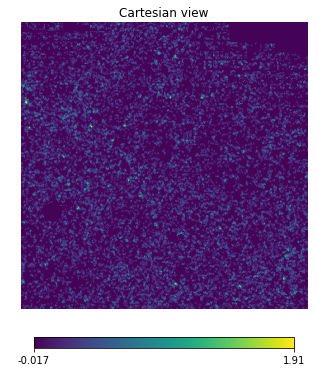

In [18]:
hp.cartview(fullmap,lonra=[0,5], latra=[0,5])

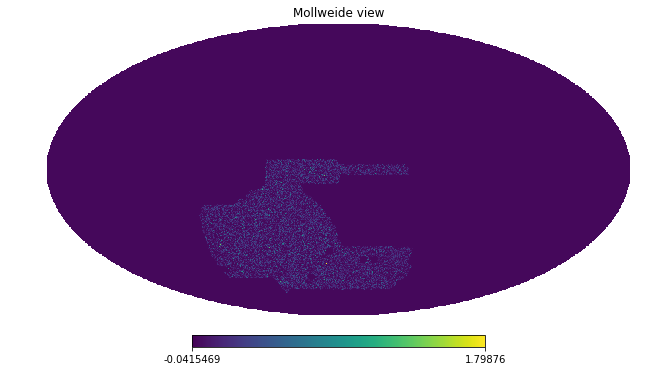

In [15]:
hp.mollview(fullmap)

/home/mlokken/.local/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)


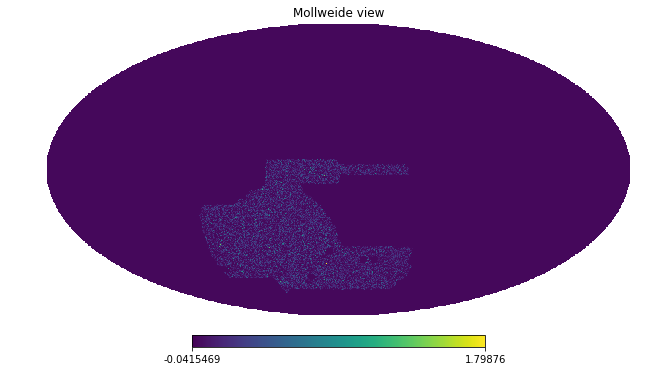

In [16]:
hp.mollview(fullmap)
if mode == 'buzzard':
#     hp.write_map("/mnt/raid-cita/mlokken/buzzard/number_density_maps/des_reg/all_redmagic_1pt6a.fits", fullmap, overwrite=True)
    hp.write_map("/mnt/raid-cita/mlokken/buzzard/number_density_maps/des_reg/all_redmagic_nd_1pt6a.fits", fullmap, overwrite=True)
elif mode == 'des':
#     hp.write_map("/mnt/raid-cita/mlokken/data/number_density_maps/all_redmagic_1pt6a.fits", fullmap)
    hp.write_map("/mnt/raid-cita/mlokken/data/number_density_maps/all_redmagic_nd_1pt6a.fits", fullmap)

Mean of number density map:  0.01622885982021667
Mean of overdensity map:  -1.973649891289376e-15
Mean of number density map:  0.02893788980341236
Mean of overdensity map:  5.8457607152764764e-15
Mean of number density map:  0.043514031532810436
Mean of overdensity map:  3.168351342206348e-14


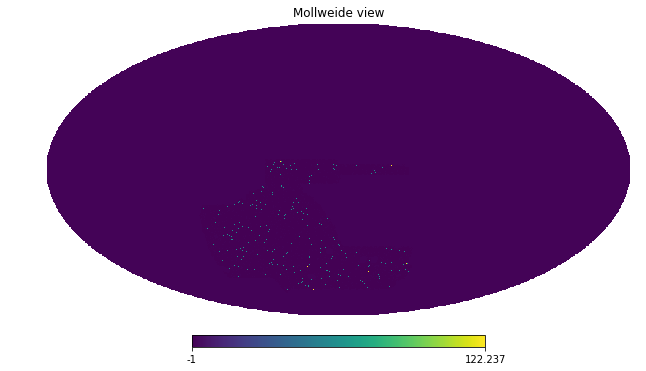

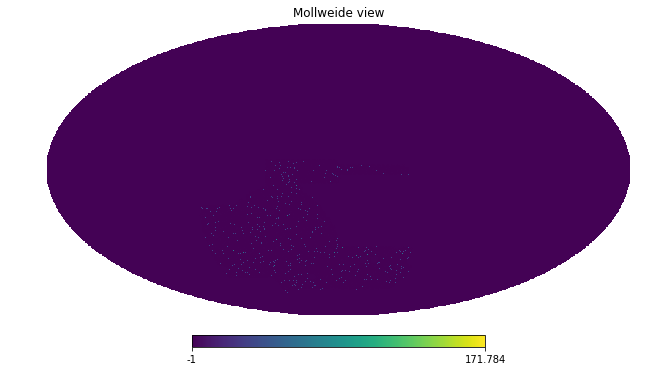

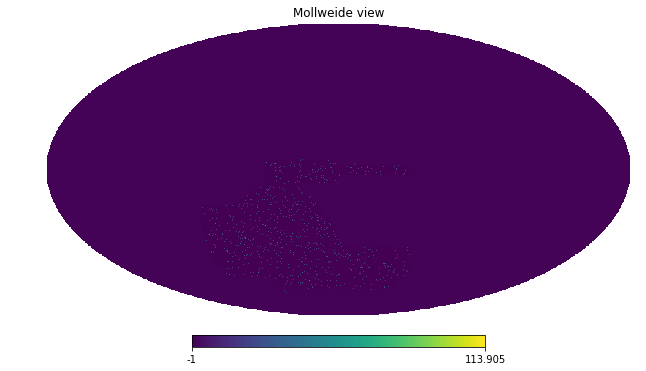

In [17]:
zbins = [[0.15,0.35],[0.35,0.5], [0.5,0.65]]
c = 1
for z in zbins:
    z_cond = (rm_z < z[1]) & (rm_z > z[0])
    galmap = get_hp_map(4096,rm_ra[z_cond],rm_dec[z_cond], rm_mask, 0)
    if mode == 'buzzard':
        hp.write_map("/mnt/scratch-lustre/mlokken/buzzard/number_density_maps/des_reg/3_zbins_grf_comparison/buzzard_redmagic_highdens_zbin{:d}_od_map_nosmooth.fits".format(c), galmap, overwrite=True)
    if mode == 'des':
        hp.write_map("/mnt/scratch-lustre/mlokken/data/number_density_maps/3_zbins_grf_comparison/redmagic_highdens_zbin{:d}_od_map_nosmooth.fit".format(c), galmap, overwrite=True)
    c += 1

In [7]:
# redmapper cls
rm_hdu = fits.open("/mnt/scratch-lustre/mlokken/buzzard/catalogs/buzzard_1.9.9_3y3a_rsshift_run_redmapper_v0.5.1_lgt05_vl50_catalog.fit")
rm_cls = rm_hdu[1].data
rm_hdr = rm_hdu[1].header
rm_hdu.close()

In [8]:
rm_cls = rm_cls[rm_cls['LAMBDA']>7]
rm_cls_midz = rm_cls[(rm_cls['z_lambda']<0.5) & (rm_cls['z_lambda']>0.35)]
def DeclRatoThetaPhi(decl,RA):
    return np.radians(-decl+90.),np.radians(RA)
theta, phi = DeclRatoThetaPhi(rm_cls_midz['DEC'], rm_cls_midz['RA'])

In [9]:
thetaphi = np.zeros((len(rm_cls_midz), 2))
thetaphi[:,0] = theta
thetaphi[:,1] = phi
np.savetxt("/mnt/scratch-lustre/mlokken/buzzard/clusters_to_stack/buzzard_1.9.9_3y3a_rsshift_run_redmapper_v0.5.1_lgt05_vl50/des_reg/thetaphi_midz.txt",thetaphi)